# Pgnet Model with MVN Resampling

In [1]:
import time
import os
import sys

import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.set()

import jax
import jax.numpy as jnp
import jax.random as random

import pfjax as pf
from pfjax import models
import optax
from functools import partial
import projplot as pjp

import warnings
warnings.filterwarnings('ignore')

## No DNA

In [2]:
key = random.PRNGKey(0)

theta = np.array([0.1, 0.7, 0.35, 0.2, 0.1, 0.9, 0.3, 0.1])
tau = np.array([1,1,1])*1

DNA_init = np.array([5])

theta = np.concatenate([theta, tau, DNA_init])
dt = .1
n_res = 1
n_obs = 50

pgnet_dna = models.PGNETModelNoDNA(dt, n_res)
pgnet_dna_bridge = models.PGNETModelNoDNA(dt, n_res, bootstrap = False)

key, subkey = random.split(key)

x_init = jnp.block([[jnp.zeros((n_res-1, 4))],
                   [jnp.log(jnp.array([8., 8., 8., 5.]))]])

y_meas, x_state = pf.simulate(pgnet_dna, subkey, n_obs, x_init, theta)

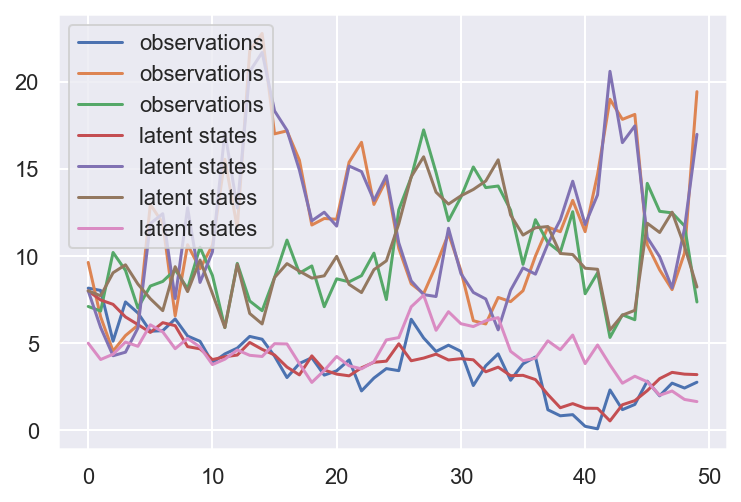

In [3]:
plt.plot(y_meas, label = "observations");
plt.plot(jnp.exp(x_state.squeeze()), label = "latent states")
plt.legend();

In [4]:
# # log-likelihood for Lotvol model with MVN resamplings
# @jax.partial(jax.jit, static_argnums=(1,2, ))
# def pf_neg_loglik(theta, resampler = pf.particle_resample_mvn):
#     """
#     Negative log-likelihood for lotka volterra model (lotvol_model)
#     """
#     temp = pf.particle_filter(
#         theta=theta, 
#         model=pgnet_dna, 
#         y_meas=y_meas, 
#         n_particles=n_particles, key=key,
#         particle_sampler = resampler)
#     return -pf.particle_loglik(temp['logw'])


# bridge
@jax.partial(jax.jit, static_argnums=(1,2, ))
def pf_neg_loglik_bridge(theta, resampler = pf.particle_resample_mvn):
    """
    Negative log-likelihood for lotka volterra model (lotvol_model)
    """
    temp = pf.particle_filter(
        theta=theta, 
        model=pgnet_dna_bridge, 
        y_meas=y_meas, 
        n_particles=n_particles, key=key,
        particle_sampler = resampler)
    return -pf.particle_loglik(temp['logw'])

In [14]:
theta_lims = np.array([[0, 0.5], 
                       [0,1], 
                       [0, 1],
                       [0, 1], 
                       [0, 1], 
                       [0.5, 1], 
                       [0, 0.5], 
                       [0, 0.5],
                       [1, 1], 
                       [1, 1], 
                       [1, 1], 
                       [5, 5]])
theta_names = ["theta0", "theta1", "theta2", "theta3",
               "theta4", "theta5", "theta6", "theta7",
               "tau0", "tau1", "tau2", "tau3"]

In [ ]:
n_particles = 1000

plot_mvn = pf.proj_data(
    fun = lambda x: pf_neg_loglik_bridge(x), 
    theta = theta, 
    theta_lims = theta_lims, 
    theta_names = theta_names)

plot_multinom = pf.proj_data(
    fun = lambda x: pf_neg_loglik_bridge(x, resampler = pf.particle_resample),
    theta = theta, 
    theta_lims = theta_lims, 
    theta_names = theta_names)

plot_mvn["method"] = "mvn"
plot_multinom["method"] = "multinomial"
df = pd.concat([plot_multinom, plot_mvn]).reset_index(drop=True)

grid = sns.relplot(
    data=df, 
    kind="line",
    hue = "method",
    x="x", y="y", 
    col="theta",
    col_wrap=4,
    facet_kws=dict(sharex=False, sharey=False)
).set(title=f"PGNET, n_res={n_res}")

for ind, _ax in enumerate(grid.axes.flat):
    _ax.axvline(theta[ind], color='red', lw = 0.75);

In [13]:
# Fix parameters and run both filters with these: 
init_params = theta
n_particles = 250
n_iter = 50
learning_rate = 1e-3

mvn_params, mvn_losses, mvn_steps = simple_grad_descent(
    key = key,
    model = pgnet_dna_bridge,
    grad_fun = particle_neg_loglik_mvn,
    y_meas = y_meas,
    theta = init_params,
    learning_rate = learning_rate,
    n_iter = n_iter,
    n_particles = n_particles,
    mask=np.ones(len(init_params)),
    verbose = False
)

print("Estimated params: ", mvn_params)

Estimated params:  [nan nan nan nan nan nan nan nan nan nan nan nan]


## DNA Observed

In [2]:
key = random.PRNGKey(0)

theta = np.array([0.1, 0.7, 0.35, 0.2, 0.1, 0.9, 0.3, 0.1])
tau = np.array([1,1,1,1])*1

theta = np.concatenate([theta, tau])
dt = .1
n_res = 1
n_obs = 50

pgnet_model = models.PGNETModel(dt, n_res)
pgnet_bridge = models.PGNETModel(dt, n_res, bootstrap=False)

key, subkey = random.split(key)

x_init = jnp.block([[jnp.zeros((n_res-1, 4))],
                   [jnp.log(jnp.array([8., 8., 8., 5.]))]])

y_meas, x_state = pf.simulate(pgnet_model, subkey, n_obs, x_init, theta)

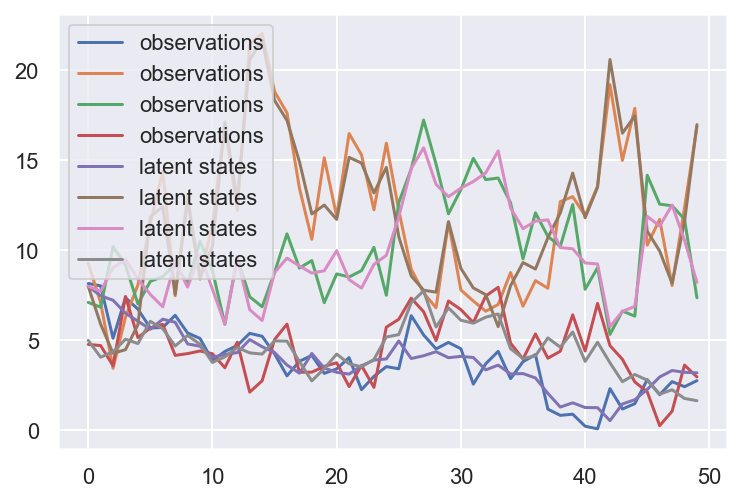

In [3]:
plt.plot(y_meas, label = "observations");
plt.plot(jnp.exp(x_state.squeeze()), label = "latent states")
plt.legend();

In [4]:
def proj_data(fun, x, x_lims, x_names, n_pts=100):
    """
    Wrapper for projxvals and projdata.
    """
    xvals = pjp.projxvals(x, x_lims, n_pts)
    return pjp.projdata(fun, xvals, x_names, is_vectorized=False)

In [5]:
theta_lims = np.array([[0, 0.5], 
                       [0,1], 
                       [0, 1],
                       [0, 1], 
                       [0, 1], 
                       [0.5, 1], 
                       [0, 0.5], 
                       [0, 0.5],
                       [0.4, 2], 
                       [0.4, 2], 
                       [0.4, 2], 
                       [0.4, 2]])
theta_names = ["theta0", "theta1", "theta2", "theta3",
               "theta4", "theta5", "theta6", "theta7",
               "tau0", "tau1", "tau2", "tau3"]

In [6]:
# log-likelihood for Lotvol model with MVN resamplings
@jax.partial(jax.jit, static_argnums=(1,2, ))
def pf_neg_loglik(theta, model = pgnet_model, resampler = pf.particle_resample_mvn):
    """
    Negative log-likelihood for lotka volterra model (lotvol_model)
    """
    temp = pf.particle_filter(
        theta=theta, 
        model=model, 
        y_meas=y_meas, 
        n_particles=n_particles, key=key,
        particle_sampler = resampler)
    return -pf.particle_loglik(temp['logw'])

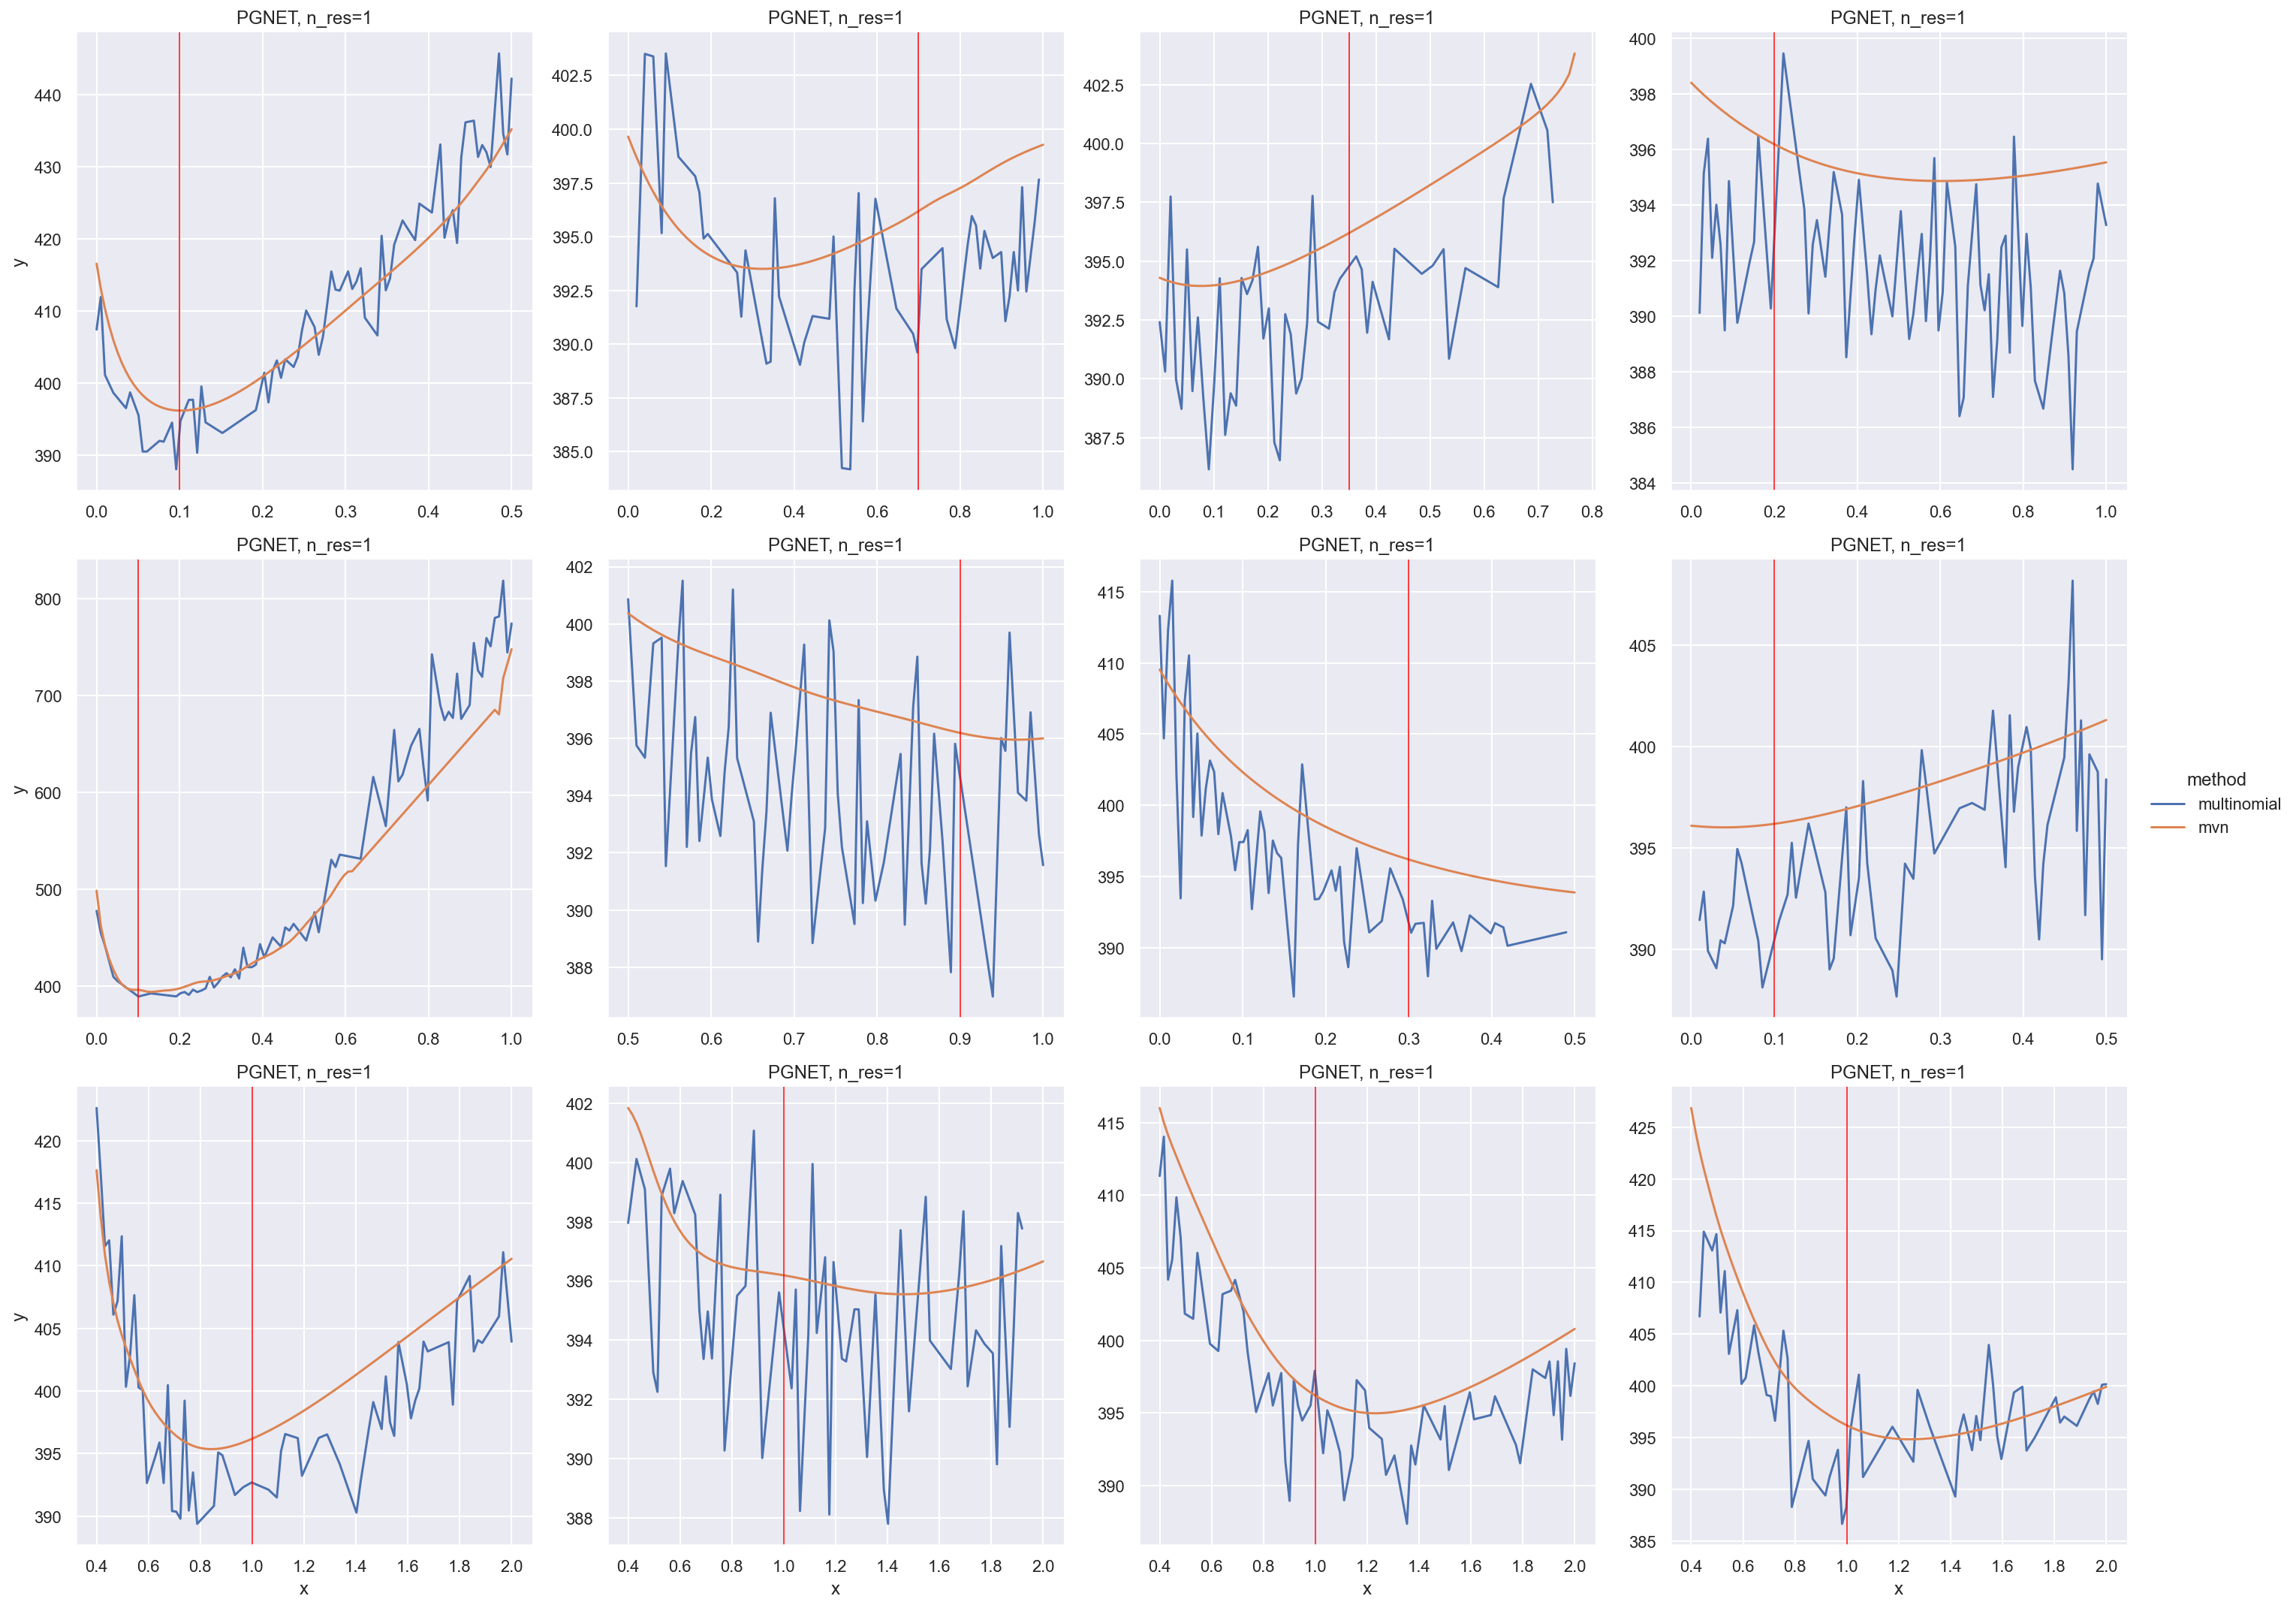

In [7]:
n_particles = 500

plot_mvn = pf.proj_data(
    fun = lambda x: pf_neg_loglik(x), 
    theta = theta, 
    theta_lims = theta_lims, 
    theta_names = theta_names)

plot_multinom = pf.proj_data(
    fun = lambda x: pf_neg_loglik(x, resampler = pf.particle_resample),
    theta = theta, 
    theta_lims = theta_lims, 
    theta_names = theta_names)

plot_mvn["method"] = "mvn"
plot_multinom["method"] = "multinomial"
df = pd.concat([plot_multinom, plot_mvn]).reset_index(drop=True)

grid = sns.relplot(
    data=df, 
    kind="line",
    hue = "method",
    x="x", y="y", 
    col="theta",
    col_wrap=4,
    facet_kws=dict(sharex=False, sharey=False)
).set(title=f"PGNET, n_res={n_res}")

for ind, _ax in enumerate(grid.axes.flat):
    _ax.axvline(theta[ind], color='red', lw = 0.75);

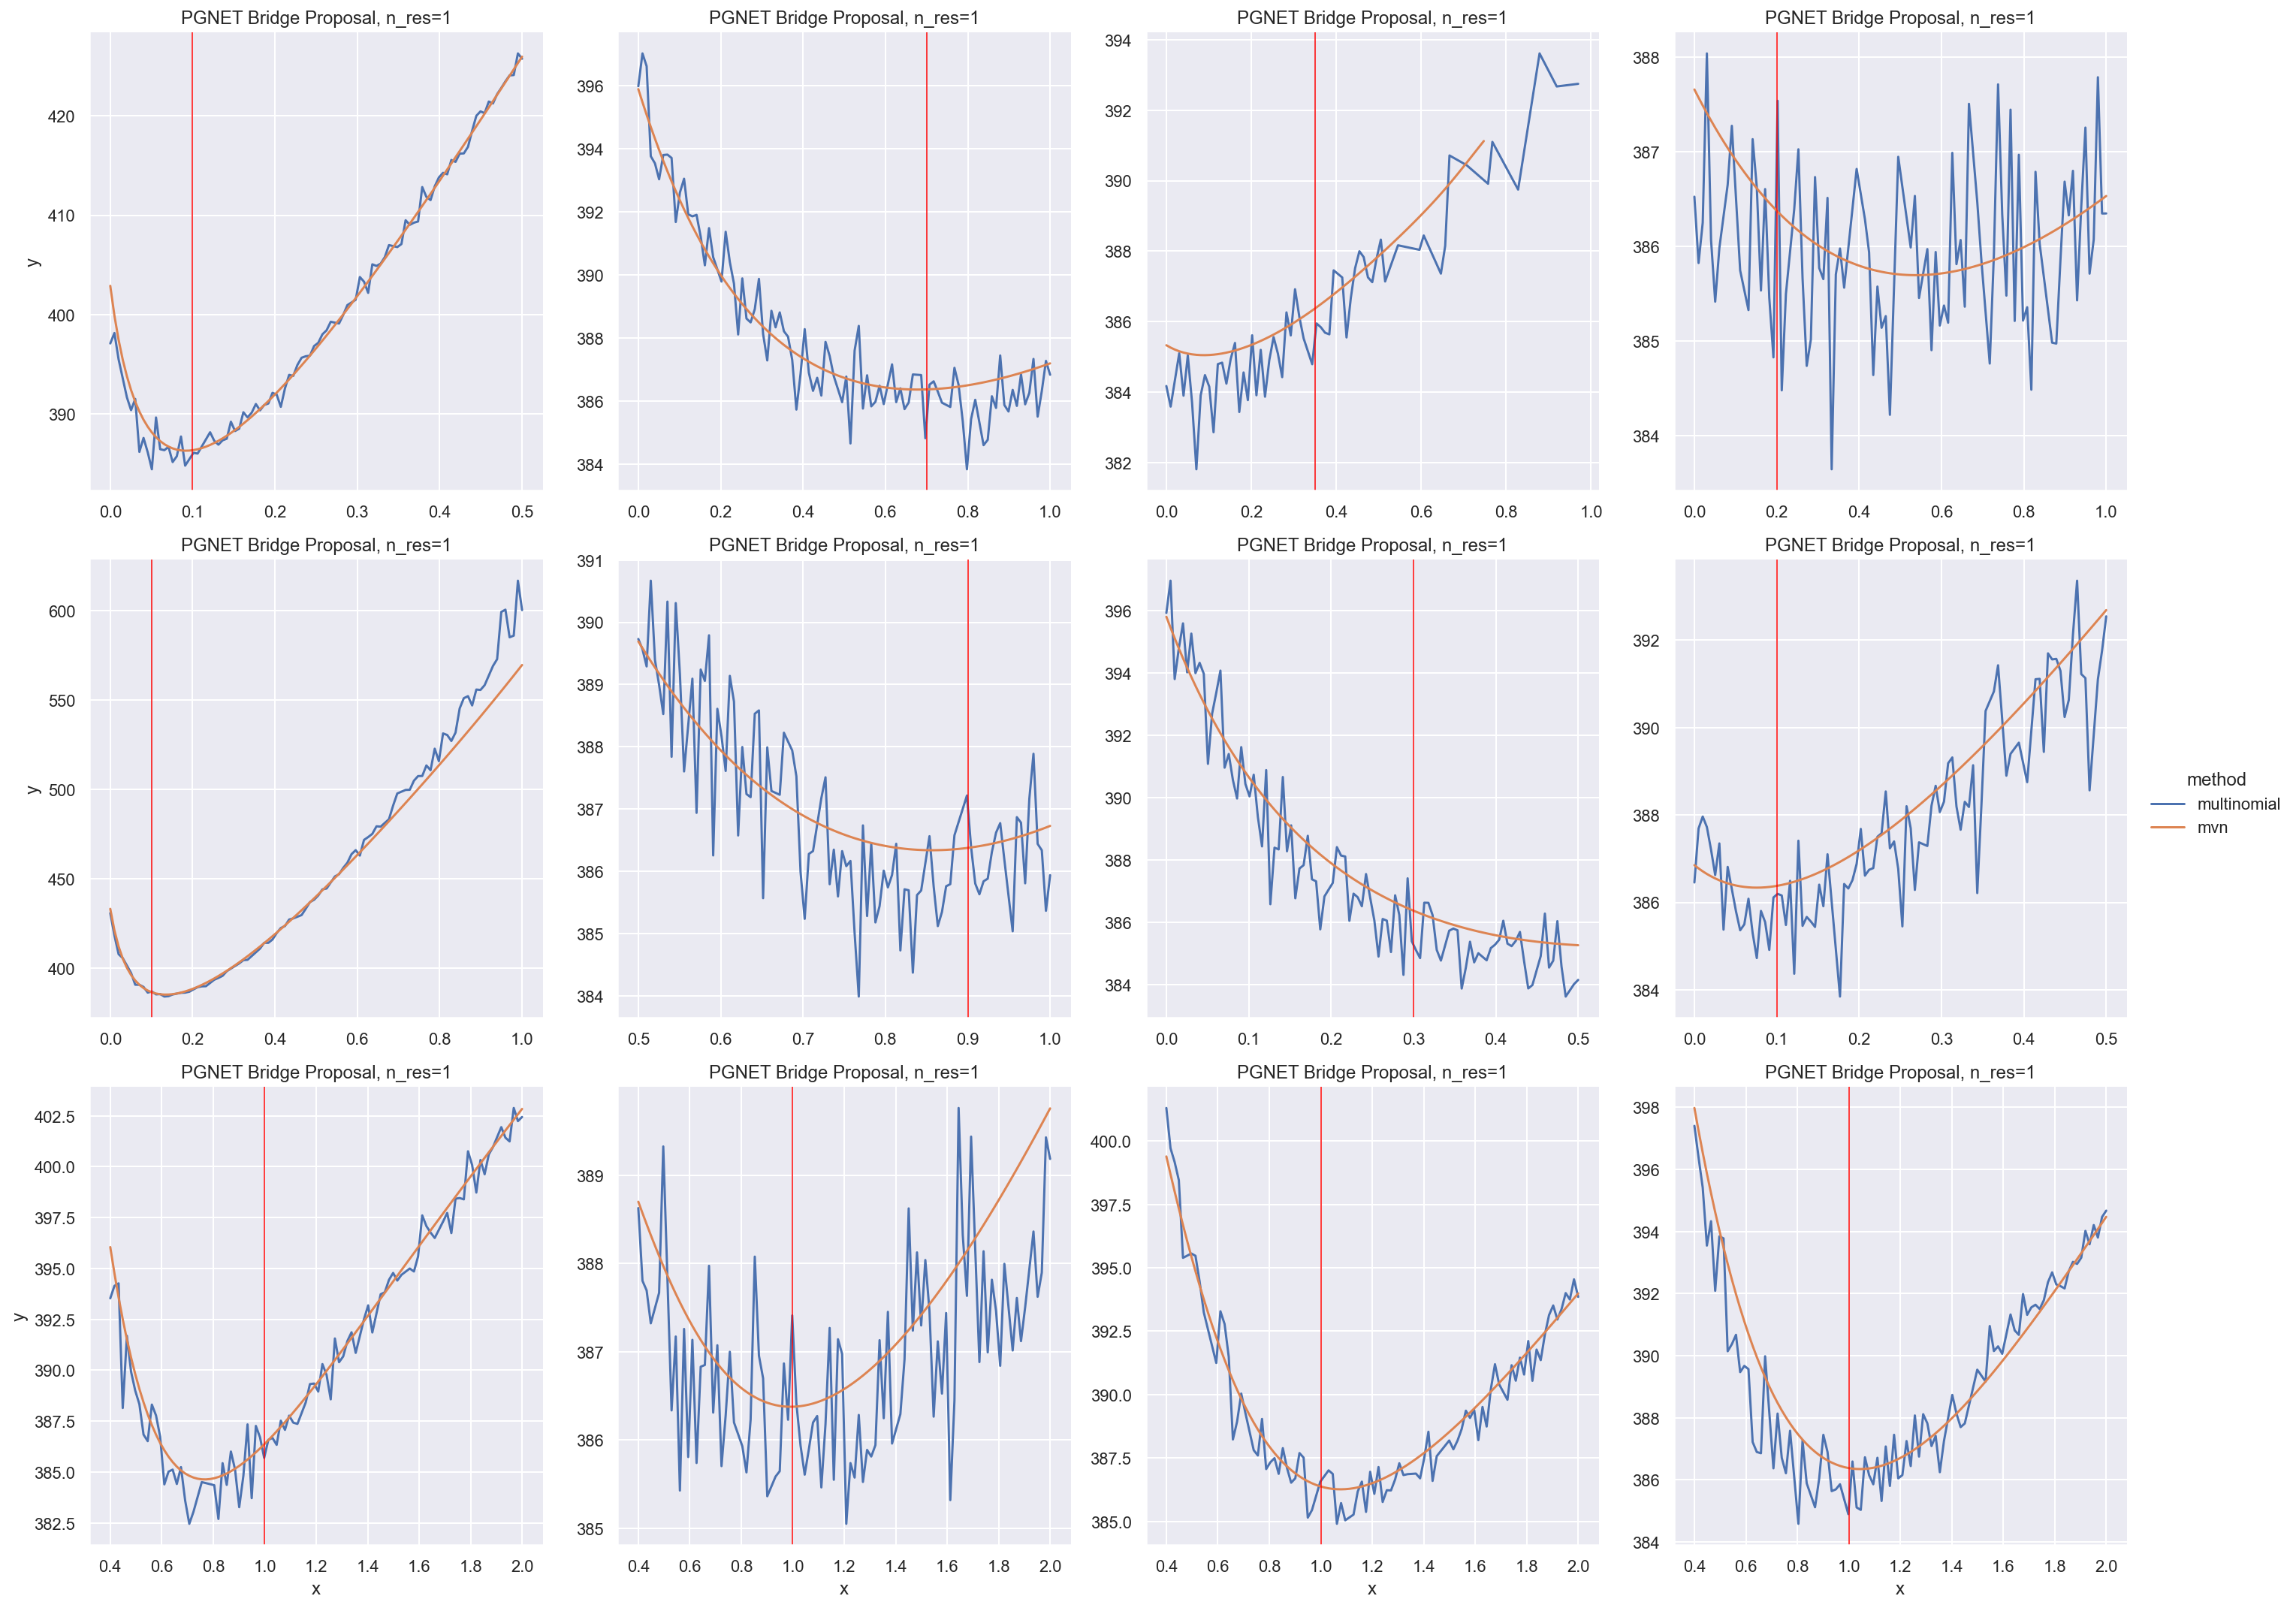

In [8]:
n_particles = 500

plot_mvn = pf.proj_data(
    fun = lambda x: pf_neg_loglik(x, model = pgnet_bridge), 
    theta = theta, 
    theta_lims = theta_lims, 
    theta_names = theta_names)

plot_multinom = pf.proj_data(
    fun = lambda x: pf_neg_loglik(x, model = pgnet_bridge, resampler = pf.particle_resample),
    theta = theta, 
    theta_lims = theta_lims, 
    theta_names = theta_names)

plot_mvn["method"] = "mvn"
plot_multinom["method"] = "multinomial"
df = pd.concat([plot_multinom, plot_mvn]).reset_index(drop=True)

grid = sns.relplot(
    data=df, 
    kind="line",
    hue = "method",
    x="x", y="y", 
    col="theta",
    col_wrap=4,
    facet_kws=dict(sharex=False, sharey=False)
).set(title=f"PGNET Bridge Proposal, n_res={n_res}")

for ind, _ax in enumerate(grid.axes.flat):
    _ax.axvline(theta[ind], color='red', lw = 0.75);

## Inference with Bridge Propsal

In [11]:
# @jax.partial(jax.jit, static_argnums=(1,2, 3, 4, ))
def particle_neg_loglik_mvn(theta, key, n_particles, y_meas, model):
    ret = pf.particle_filter(model, key, y_meas, theta, 
                             n_particles, 
                             particle_sampler=pf.particle_resample_mvn)
    return -pf.particle_loglik(ret['logw'])

# @jax.partial(jax.jit, static_argnums=(1,2, 3, 4, ))
def particle_neg_loglik(theta, key, n_particles, y_meas, model):
    ret = pf.particle_filter(model, key, y_meas, theta, 
                             n_particles)
    return -pf.particle_loglik(ret['logw'])

def update_params(params, subkey, opt_state, grad_fun=None, n_particles=100, 
                  y_meas=None, model=None, learning_rate=0.01, mask=None,
                  optimizer=None):
    loglik_value, params_update = jax.value_and_grad(grad_fun, argnums=0)(
        params, subkey, n_particles, y_meas, model)
    params_update = jnp.where(mask, params_update, 0)
    updates, opt_state = optimizer.update(params_update, opt_state)
    return optax.apply_updates(params, updates), loglik_value


def simple_grad_descent (model, theta, grad_fun, y_meas, n_particles=100, 
                         n_iter=10, learning_rate=0.01, key=1, mask=None, verbose = False):
    """ Deterministic optimization """
    optimizer = optax.adam(learning_rate) 
    opt_state = optimizer.init(theta)
    partial_update_params = partial(update_params, n_particles=n_particles, y_meas=y_meas,
                                    model=model, learning_rate=learning_rate, mask=mask, 
                                    grad_fun=grad_fun, optimizer=optimizer)
    update_fn = jax.jit(partial_update_params, donate_argnums=(0,))
    losses = []
    thetas = []
    for i in range(n_iter):
        # get value of loss function to make sure we are minimizing 
        theta, loglik_value = update_fn(theta, subkey, opt_state)
        losses.append(loglik_value)
        thetas.append(theta)
        if verbose: 
            print(f"Log-likelihood: {loglik_value}")
    return theta, losses, thetas


def stoch_opt(model, theta, grad_fun, y_meas, n_particles=100, 
              n_iter=10, learning_rate=0.01, key=1, mask=None):
    optimizer = optax.adam(learning_rate)
    opt_state = optimizer.init(theta)
    partial_update_params = partial(update_params, n_particles=n_particles, y_meas=y_meas,
                                    model=model, learning_rate=learning_rate, mask=mask, grad_fun=grad_fun, 
                                    optimizer=optimizer)
    update_fn = jax.jit(partial_update_params, donate_argnums=(0,))
    keys = random.split(key, n_iter)
    losses = []
    thetas = []
    for subkey in keys:
        theta, loglik_value = update_fn(theta, subkey, opt_state)
        losses.append(loglik_value)
        thetas.append(theta)
    return theta, losses, thetas

In [10]:
init_params = jnp.array([0.05, 0.5, 0.35, 0.2, 0.1, 0.9, 0.3, 0.1, 1., 1., .8, .8])
print("True params:    ", theta)
print("Initial params: ", init_params)

True params:     [0.1  0.7  0.35 0.2  0.1  0.9  0.3  0.1  1.   1.   1.   1.  ]
Initial params:  [0.05 0.5  0.35 0.2  0.1  0.9  0.3  0.1  1.   1.   0.8  0.8 ]


In [11]:
# Fix parameters and run both filters with these: 
n_particles = 250
n_iter = 50
learning_rate = 1e-3

mvn_params, mvn_losses, mvn_steps = simple_grad_descent(
    key = key,
    model = pgnet_bridge,
    grad_fun = particle_neg_loglik_mvn,
    y_meas = y_meas,
    theta = init_params,
    learning_rate = learning_rate,
    n_iter = n_iter,
    n_particles = n_particles,
    mask=np.ones(len(init_params)),
    verbose = False
)

print("Estimated params: ", mvn_params)

Estimated params:  [0.08199982 0.54999936 0.30000064 0.24999936 0.14199965 0.93999946
 0.34999937 0.0640002  0.95000064 1.0500023  0.84999937 0.84999937]


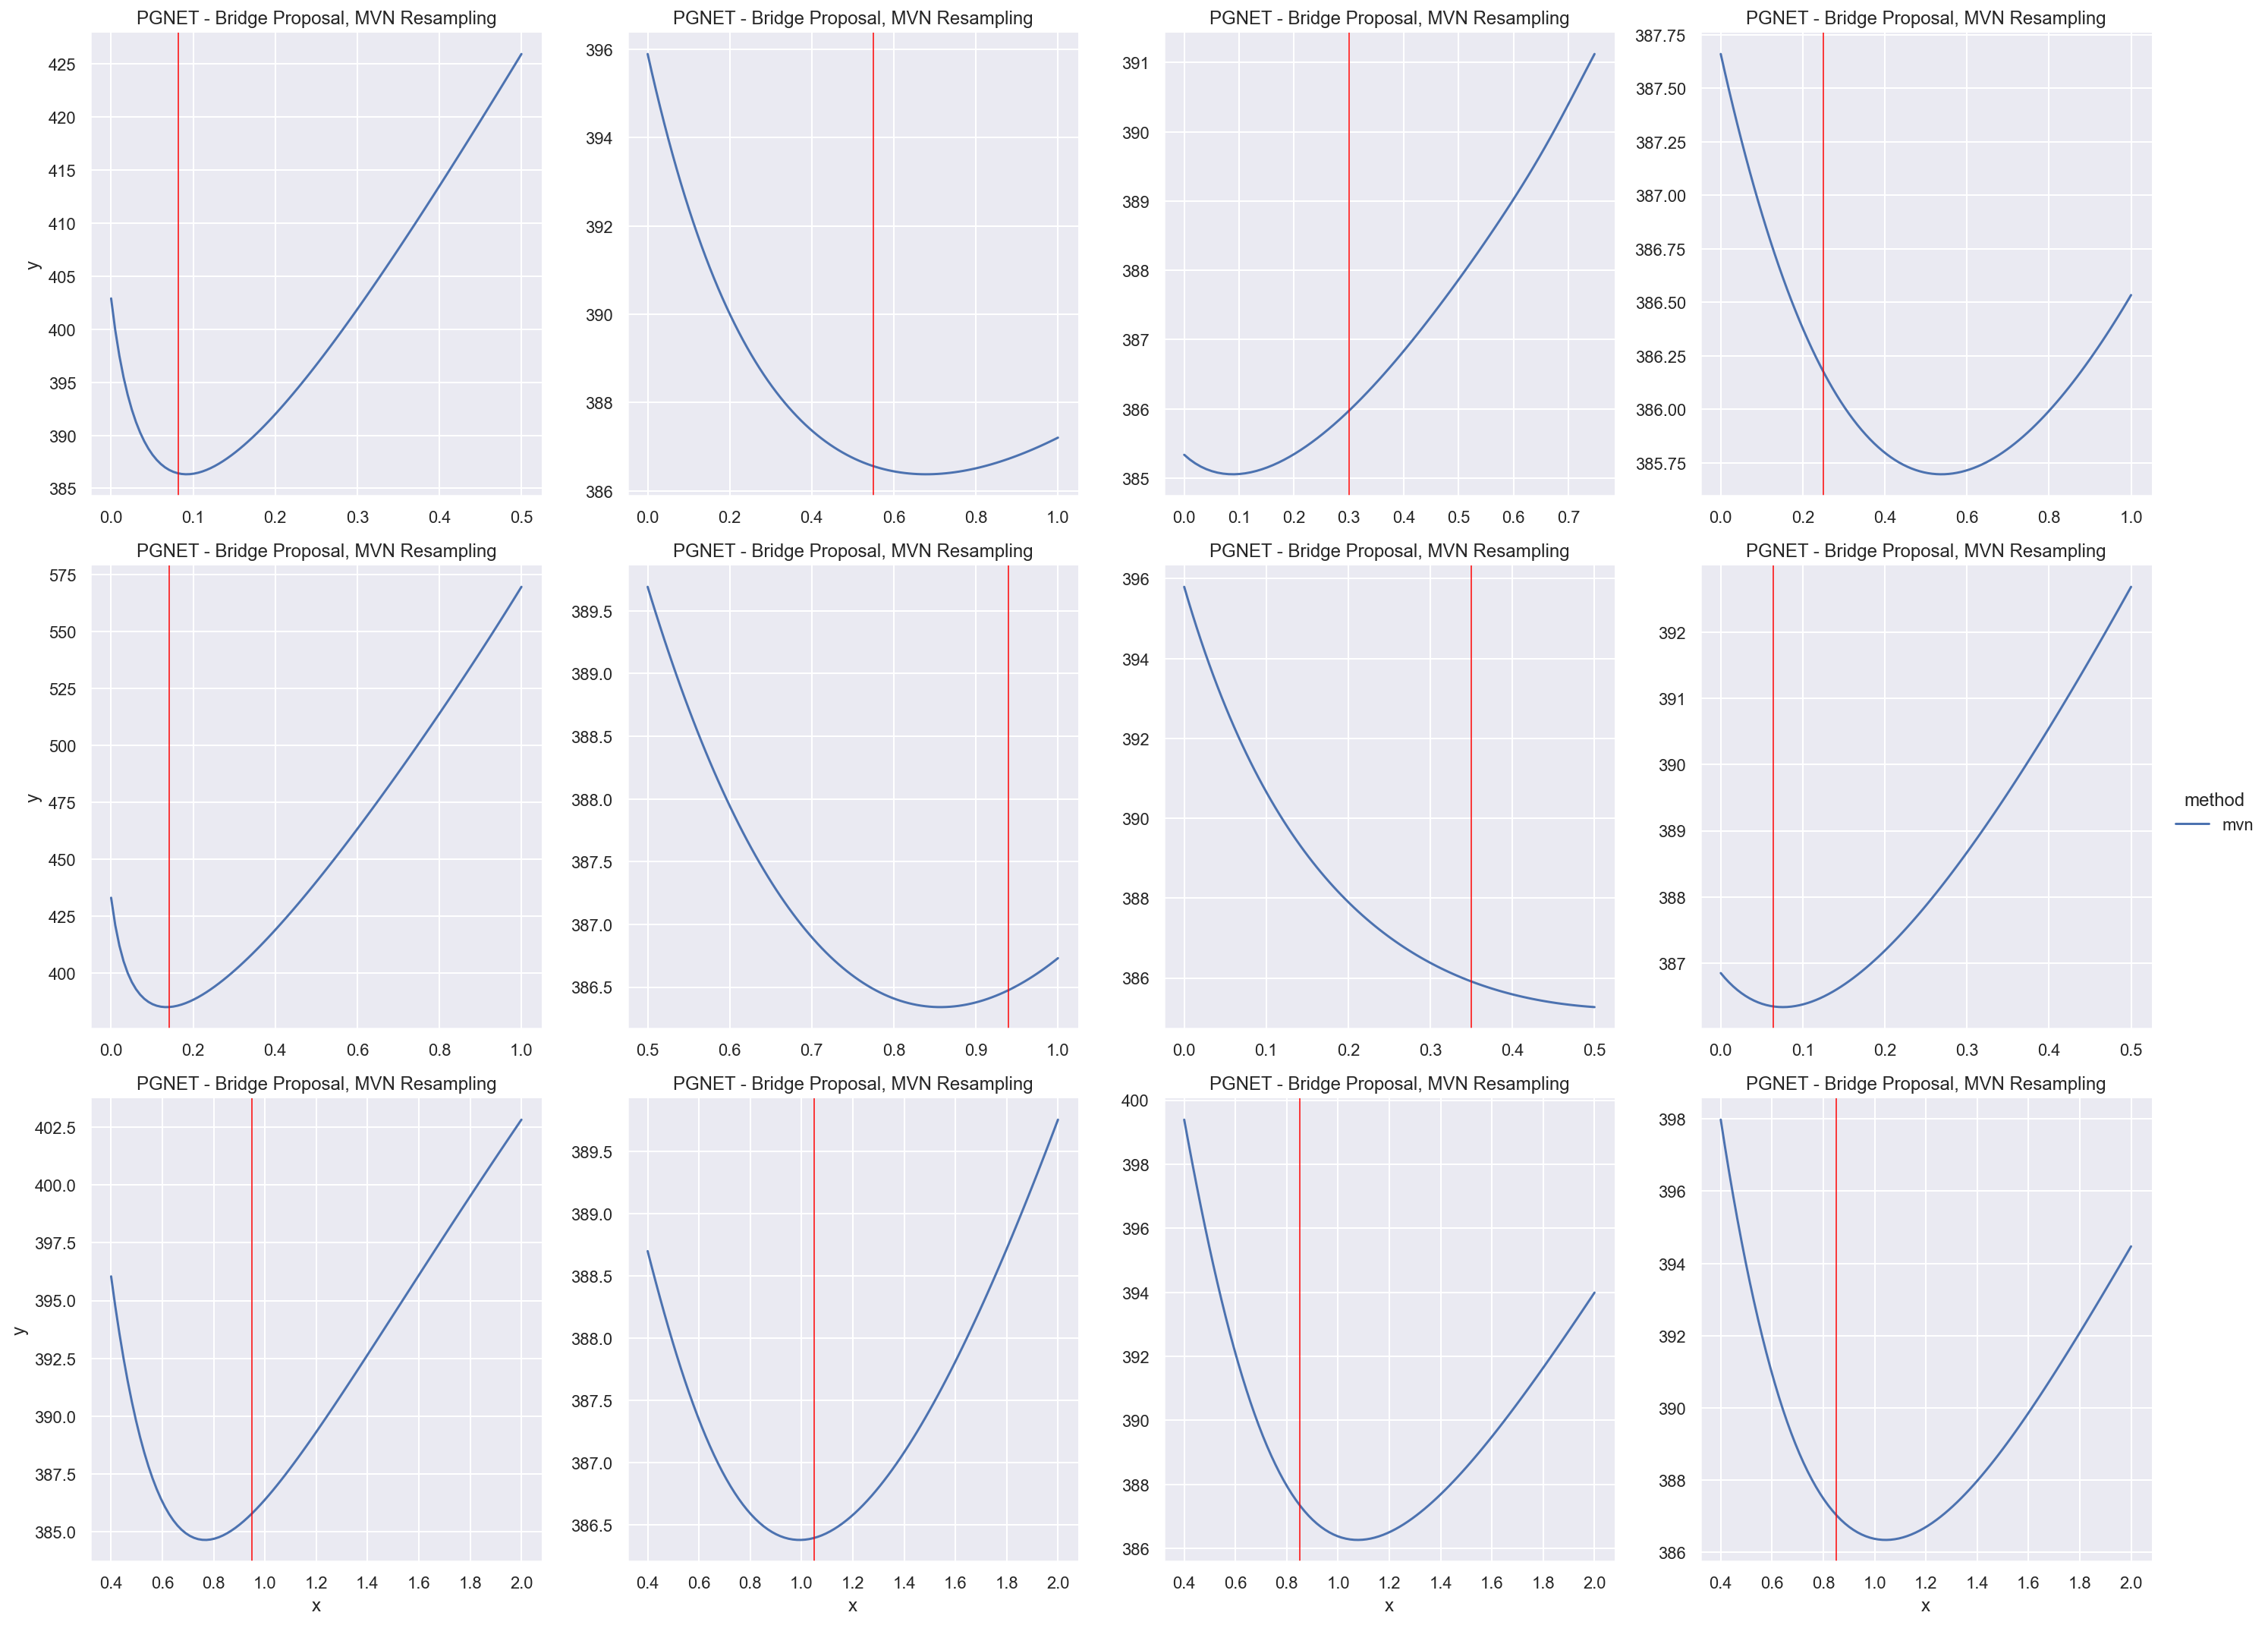

In [12]:
grid = sns.relplot(
    data=plot_mvn, 
    kind="line",
    hue = "method",
    x="x", y="y", 
    col="theta",
    col_wrap=4,
    facet_kws=dict(sharex=False, sharey=False)
).set(title="PGNET - Bridge Proposal, MVN Resampling")

for ind, _ax in enumerate(grid.axes.flat):
    _ax.axvline(mvn_params[ind], color='red', lw = 0.75);

In [13]:
# Fix parameters and run both filters with these: 
n_particles = 250
n_iter = 50
learning_rate = 1e-4

multinom_params, multinom_losses, multinom_steps = stoch_opt(
    key = key,
    model = pgnet_bridge,
    grad_fun = particle_neg_loglik,
    y_meas = y_meas,
    theta = init_params,
    learning_rate = learning_rate,
    n_iter = n_iter,
    n_particles = n_particles,
    mask=np.ones(len(init_params))
)

print("Estimated params: ", multinom_params)

Estimated params:  [0.0549999  0.49900013 0.34500065 0.20480008 0.10500009 0.8959993
 0.30499935 0.09859998 0.9949992  1.0044007  0.80500084 0.80500084]


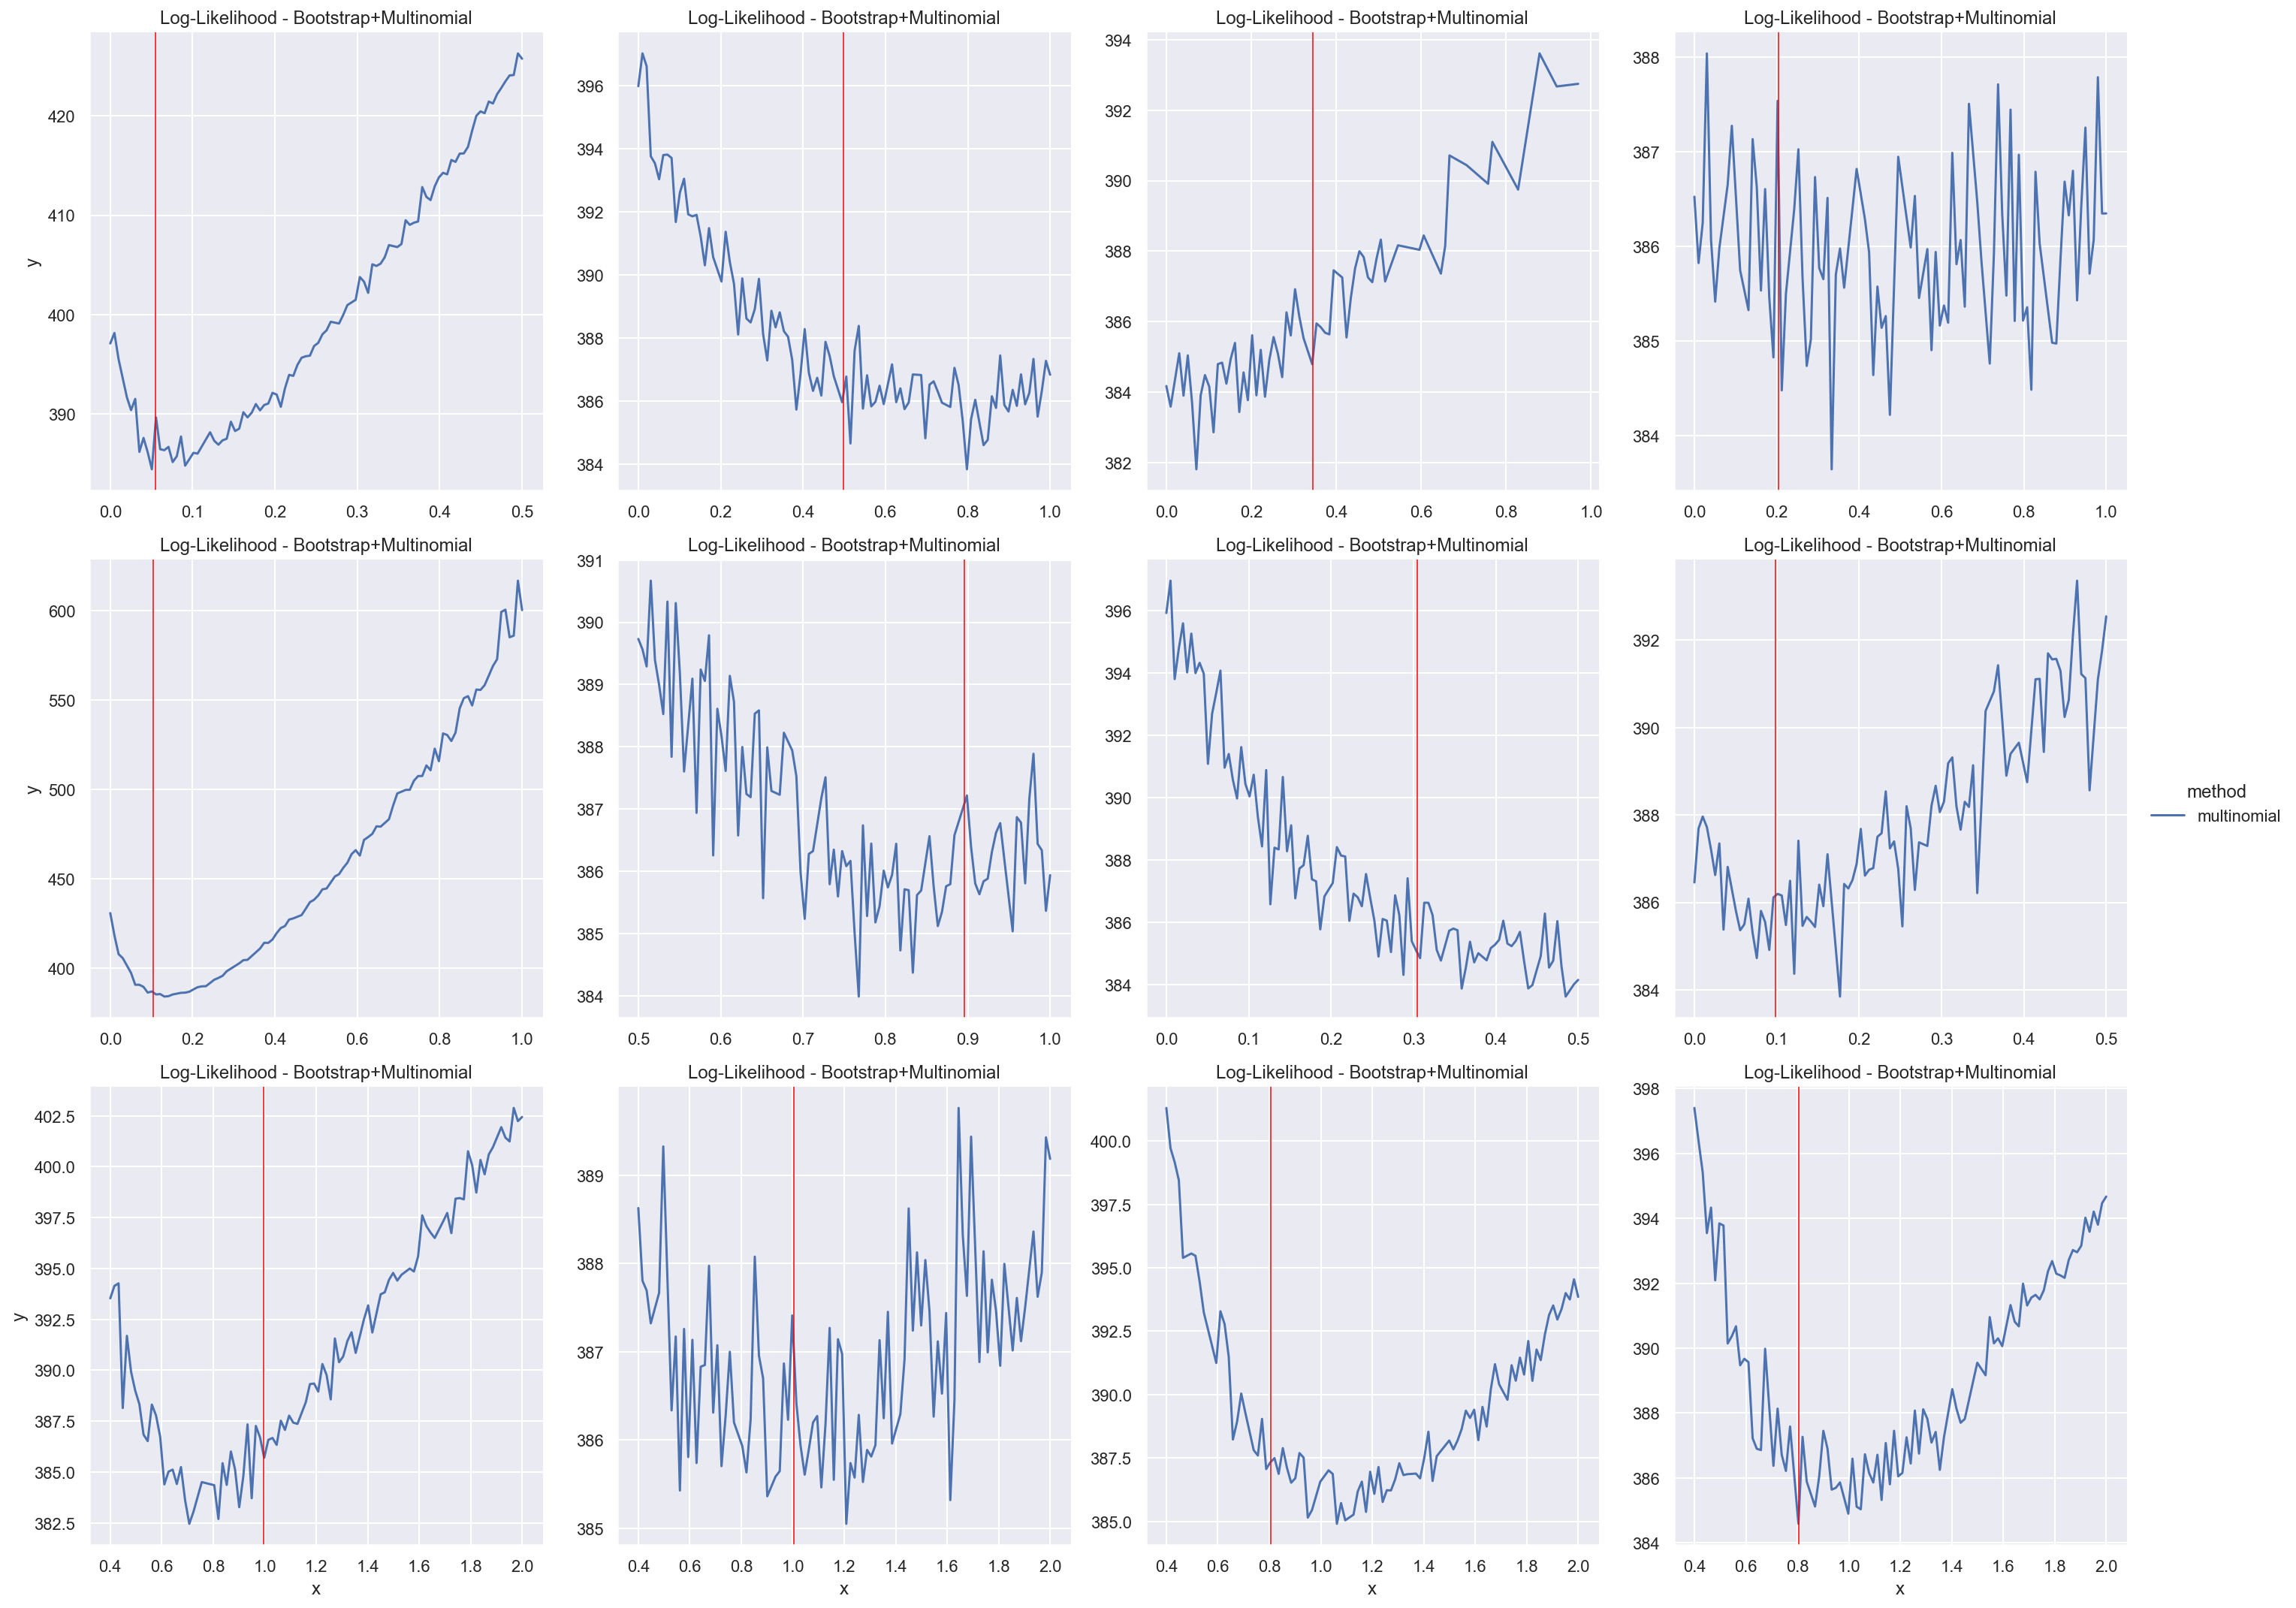

In [14]:
grid = sns.relplot(
    data=plot_multinom, 
    kind="line",
    hue = "method",
    x="x", y="y", 
    col="theta",
    col_wrap=4,
    facet_kws=dict(sharex=False, sharey=False)
).set(title="Log-Likelihood - Bootstrap+Multinomial");

for ind, _ax in enumerate(grid.axes.flat):
    _ax.axvline(multinom_params[ind], color='red', lw = 0.75);